Script 1:
- Overview of the original data
- Rough data cleaning: missing values
- Explore Data Analysis
- Hierarchical Clustering

In [41]:
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
from plotnine import *
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

from IPython.display import HTML

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder


## Import Data

In [25]:
path='./home-credit-default-risk/'

df = pd.read_csv(path + 'application_train.csv')
df_combined = pd.read_csv('combined_clean.csv')

bureau_balance = pd.read_csv(path + 'bureau_balance.csv')
bureau = pd.read_csv(path + 'bureau.csv')
credit_card_balance = pd.read_csv(path + 'credit_card_balance.csv')
installments_payments = pd.read_csv(path + 'installments_payments.csv')
POS_CASH_balance = pd.read_csv(path + 'POS_CASH_balance.csv')
previous_application = pd.read_csv(path + 'previous_application.csv')

In [19]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


we have 9 datasets, their relationships follows this graph:
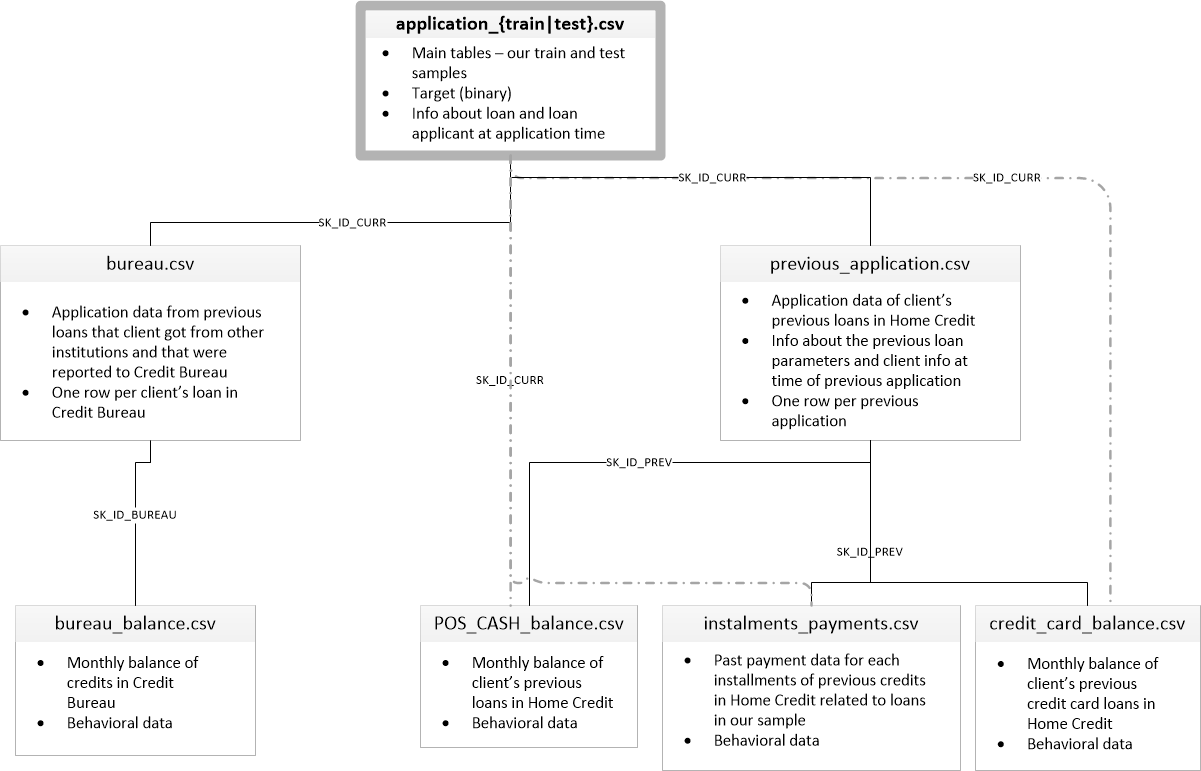

## Abstract

In this project, we aim to focus on predicting which features are useful to determine a client's credit and also evaluate the risk of lending loans to a specific client. We plan to use clustering and machine learning methods to select important features, visualize different features distribution, and make useful and specific analysis to evaluate each client. In our main datasets, there are more than 300,000 observations and 122 variables. There are variables such as "Loan Annuity", "annual income" which seems very related to decide whether a customer are able to pay their loans. There are also some variables such as “client's surrouding observations record" or "Did the client provide mobile phone" which are very interested to study. Excluding our main dataset "application_{train|test}.csv", we also have other datasets such as "bureau.csv","previous_application.csv" to help us evaluate each client's previous credit record and help us improve our prediction accuracy. 

## 1. Client Distribution Overview

In our datasets, around 8% of clients have payment difficulties. The rest of 92% are other cases.

In [6]:
#percentage of is_payment_difficulties
target_perc = df['TARGET'].value_counts()/df['TARGET'].count()
target_perc

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

We visualize the clients of Home Credit, using common sense to check if family status, education background, income type, and owned apartment will affect the ability for clients to pay loan.

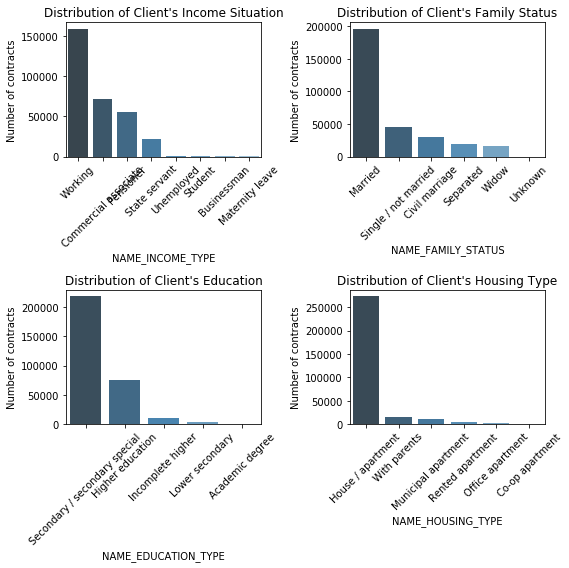

In [8]:
fig, ((axis1,axis3),(axis2,axis4)) = plt.subplots(2,2,figsize=(8,8))
income_val = df["NAME_INCOME_TYPE"].value_counts()
df_income = pd.DataFrame({"NAME_INCOME_TYPE": income_val.index,'Number of contracts': income_val.values})
sns.barplot(x = 'NAME_INCOME_TYPE', y="Number of contracts",palette='Blues_d',data=df_income,ax=axis1)
axis1.set_xticklabels(axis1.get_xticklabels(),rotation=45)
axis1.set(title = "Distribution of Client's Income Situation")

education_val = df["NAME_EDUCATION_TYPE"].value_counts()
df_education = pd.DataFrame({"NAME_EDUCATION_TYPE": education_val.index,'Number of contracts': education_val.values})
sns.barplot(x = 'NAME_EDUCATION_TYPE', y="Number of contracts",palette='Blues_d',data=df_education,ax=axis2)
axis2.set_xticklabels(axis2.get_xticklabels(),rotation=45)
axis2.set(title = "Distribution of Client's Education")

family_val = df["NAME_FAMILY_STATUS"].value_counts()
df_family = pd.DataFrame({"NAME_FAMILY_STATUS": family_val.index,'Number of contracts': family_val.values})
sns.barplot(x = 'NAME_FAMILY_STATUS', y="Number of contracts",palette='Blues_d',data=df_family,ax=axis3)
axis3.set_xticklabels(axis3.get_xticklabels(),rotation=45)
axis3.set(title = "Distribution of Client's Family Status")

housing_val = df["NAME_HOUSING_TYPE"].value_counts()
df_housing = pd.DataFrame({"NAME_HOUSING_TYPE": housing_val.index,'Number of contracts': housing_val.values})
sns.barplot(x = 'NAME_HOUSING_TYPE', y="Number of contracts",palette='Blues_d',data=df_housing,ax=axis4)
axis4.set_xticklabels(axis4.get_xticklabels(),rotation=45)
axis4.set(title = "Distribution of Client's Housing Type")

plt.tight_layout()
plt.show()

Despite of client's ability to repay loan (ignoring "TARGET" to be either 1 or 0), there is a majority group of clients in each feature signed contracts. According to these distributions graph, our first instinct to conclude the majority group of people who need financial support are married woking people who also have a high school diploma and own a house/apartment.

### 1.1 Income Type Distribution

In [9]:
income_ov = df.groupby(["TARGET","NAME_INCOME_TYPE"]).size().reset_index(name='count')
income_ov1 = income_ov[income_ov["TARGET"] == 0]
income_ov2 = income_ov[income_ov["TARGET"] == 1]

In [11]:
plotly.tools.set_credentials_file(username='Ruochen1997', api_key='sHcpeBEgeTXSFNp9Si0a')


fig = {
  "data": [
    {
      "values": income_ov1['count'],
      "labels": income_ov1['NAME_INCOME_TYPE'],
      "domain": {"column": 0},
      "name": "TARGET0",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    },
    {
      "values": income_ov2['count'],
      "labels": income_ov2['NAME_INCOME_TYPE'],
      "domain": {"column": 1},
      "name": "TARGET1",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    }],
  "layout": {
        "title":"Compare different target clients' income type",
        "grid": {"rows": 1, "columns": 2},
        "annotations": [
            {"font": {"size": 20},
                "showarrow": False,
                "text": "TARGET0",
                "x": 0.18,
                "y": 0.5
            },
            {"font": {"size": 20},
                "showarrow": False,
                "text": "TARGET1",
                "x": 0.82,
                "y": 0.5
            }
        ]
    }
}
py.iplot(fig, filename='donut')

For NAME_INCOME_TYPE feature, the distribution for payment difficulties and other cases are about the same.

### 1.2 Education Type Distribution

In [12]:
education_ov = df.groupby(["TARGET","NAME_EDUCATION_TYPE"]).size().reset_index(name='count')
education_ov1 = education_ov[education_ov["TARGET"] == 0]
education_ov2 = education_ov[education_ov["TARGET"] == 1]

In [14]:
plotly.tools.set_credentials_file(username='Ruochen1997', api_key='sHcpeBEgeTXSFNp9Si0a')

trace0 = go.Bar(x=education_ov1['NAME_EDUCATION_TYPE'],
    y=education_ov1['count'],
    name='TARGET0',
    marker=dict(color='rgb(49,130,189)'))
trace1 = go.Bar(
    x=education_ov2['NAME_EDUCATION_TYPE'],
    y=education_ov2['count'],
    name='TARGET1',
    marker=dict(color='rgb(204,204,204)',))
data = [trace0, trace1]
layout = go.Layout(
    xaxis=dict(tickangle=-45),
    barmode='group',
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='angled-text-bar')

## 2. Correlation

Other features do not have correlations with TARGET feature. Among all other features, EXT_SOURCE_1 to 3 have higher correlation with TARGET.

In [21]:
# Correlation matrix
app_corr = df.corr()

In [22]:
# Top 10 most positive correlated features with Target
app_corr['TARGET'].sort_values(ascending = False)[1:11]

DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
DAYS_REGISTRATION              0.041975
Name: TARGET, dtype: float64

In [23]:
#Top 10 most negative correlated features with Target
app_corr['TARGET'].sort_values()[0:10]

EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64

## 3. Explore Data Analysis

The quality of dataset will significant worsen the model's generalization ability. Thus, we need to check outliers, missing values, and recording errors.

### 3.1 Missing Value

The option for filling missing value is replaced by median or drop the features if the features are relatively less important or have too many missing values.

In [24]:
def missingval(data):

    miss_tot = data.isnull().sum()
    miss_perc = data.isnull().sum()/len(data)
    miss_table = pd.concat([miss_tot,miss_perc],axis = 1, keys = ['miss_tot','miss_perc']).sort_values(by = 'miss_perc',ascending = False)
    miss_table_unique = miss_table.drop_duplicates('miss_tot')
    return miss_table,miss_table_unique

In [26]:
# Missing variables
df_miss,df_miss_u = missingval(df)
df_miss[df_miss.miss_perc > 0].head()

,miss_tot,miss_perc
COMMONAREA_MEDI,214865,0.698723
COMMONAREA_AVG,214865,0.698723
COMMONAREA_MODE,214865,0.698723
NONLIVINGAPARTMENTS_MODE,213514,0.694330
NONLIVINGAPARTMENTS_AVG,213514,0.694330


In [27]:
# Drop missing value > 40%
df.drop(df_miss[df_miss.miss_perc > 0.4].index,axis = 1,inplace = True)
# Use median to fill the rest of numeric feature
df.fillna(df.median(),inplace=True)
# Create a new variable as missing value for categorical feature
df.fillna('XNA',inplace=True)

In this datasets, 49 features have more than 47% missing values. Since those features are not highly correlated with TARGET feature, we decide to drop the features. For other numeric features, since they are not highly correlated iwth TARGET feature and as well as other features, we use median to fill the missing value. For categorical data, we use XNA to represents missing values.

### 3.2 Combine Features

There are several variables which both have their average and mode as different variables in the dataset.Thus, we decide to remove those average variables and keep the mode. What's more, there are over 20 variables in the dataset call "flag_document_(a number)". All of them are catagorical variables with 0 and 1 and represent whether that clinet provide document 1,2,3....... Because the data description does not specify each documents, we combine all these "flag_document" by sum them together. This transform all 21 catagorical variables to be a numeric variable call "Document_sum": the larger the document sum value, the more information that client provide. 

In [29]:
col_file = [col for col in df.columns if 'FLAG_DOCUMENT' in col]

df_modified = df
df_modified['DOCUMENT_SUM'] = df[col_file].sum(axis=1)
df_modified.drop(col_file,axis = 1,inplace=True)

### 3.3 Reorganize Features and Drop Outliers

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c5b2de160>,
      dtype=object)

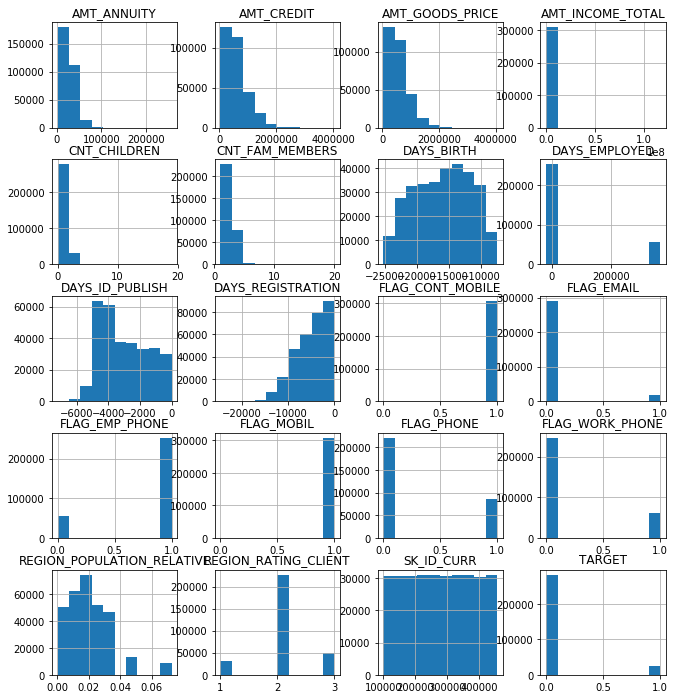

In [37]:
df_modified.iloc[:,0:30].hist(figsize=(11,12))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c5b945320>,
      dtype=object)

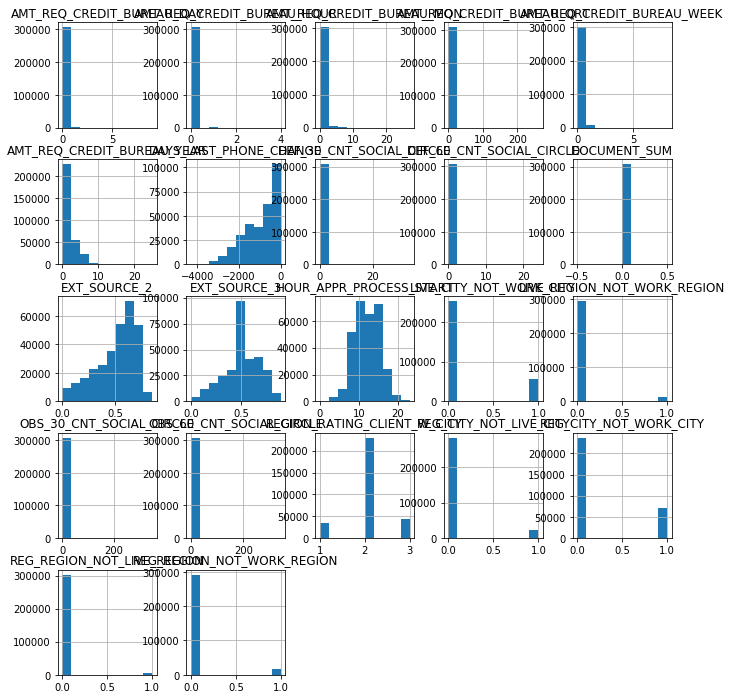

In [38]:
df_modified.iloc[:,30:].hist(figsize=(11,12))

By observing the histgram and corresponding unit of each feature, we correct some outliers and change the metric standard for better understaning the dataset app_train 

All variables related to time in this dataset such as "days from their born day", "days employed" are represented as negative values. Thus, we change these negative values to be positive and correct some variables by years instead of days. What's more, some variables such as "days_employed" has obvious outliers, the total number of outliers is 55574. It's only 18 percent of 307511 observations in app_train . So we can drop those outliers in the current setting. 

In [39]:
# Reorganize some time variables
df_modified['DAYS_EMPLOYED'] = abs(df_modified['DAYS_EMPLOYED'])
df_modified['DAYS_REGISTRATION'] = abs(df_modified['DAYS_REGISTRATION'])
df_modified['DAYS_LAST_PHONE_CHANGE'] = abs(df_modified['DAYS_LAST_PHONE_CHANGE'])

df_modified['DAYS_BIRTH'] = round(abs(df_modified['DAYS_BIRTH'])/365)
df_modified['DAYS_BIRTH'].head(20)
df_modified.rename(columns={'DAYS_BIRTH':'AGE'}, inplace=True)

# Drop replicated phone variable
df_modified = df_modified.drop(columns=['FLAG_PHONE'])

In [ ]:
# drop some outliers
df_modified.loc[df_modified['AMT_REQ_CREDIT_BUREAU_QRT'] > 10, 'AMT_REQ_CREDIT_BUREAU_QRT'] = None
df_modified.loc[df_modified['OBS_30_CNT_SOCIAL_CIRCLE'] > 20, 'OBS_30_CNT_SOCIAL_CIRCLE'] = None
df_modified.loc[df_modified['OBS_60_CNT_SOCIAL_CIRCLE'] > 20, 'OBS_60_CNT_SOCIAL_CIRCLE'] = None
df_modified.loc[df_modified['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = None # 55374 observations has outlier

In [ ]:
# Fill NA with Median
df_modified = df_modified.fillna(df_modified.median())

### 3.4 Convert Categrical Features to Numerical Features

From all these categorical features, there is no feature which has a category that can be orderd by the numerical sense such as high, low. Thus we use OrdinalEncoder to encode all these classes for each feature. It may cause different correlations between these features and other numerical feature when they are assigned differnet number to certain class, but these categorical feature will still maintain as one column. it will be easier for us to explore throgh corrleation matrix.  

In [45]:
ordinal_encoder=OrdinalEncoder()
cat_encoded=ordinal_encoder.fit_transform(df_modified.select_dtypes('object'))
df_modified.select_dtypes('object').head(2)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School


In [46]:
df_cat_encoded=pd.DataFrame(cat_encoded,columns=df_modified.select_dtypes('object').columns)
df_cat_encoded.head(2)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,0.0,1.0,0.0,1.0,6.0,7.0,4.0,3.0,1.0,8.0,6.0,5.0
1,0.0,0.0,0.0,0.0,1.0,4.0,1.0,1.0,1.0,3.0,1.0,39.0


### 3.5 Important Feature

After we did Random Forest with downsampling, we had found out some features with high feature importance score. We did data analysis and visualization on these features. The details of feature selection would be in the Script 3.

In [48]:
# Split between Target 0 & Target 1
df_combined['TARGET'] = df_combined['TARGET'].map({1:'Target 1' , 0: 'Target0'})

#### 3.5.1 Age

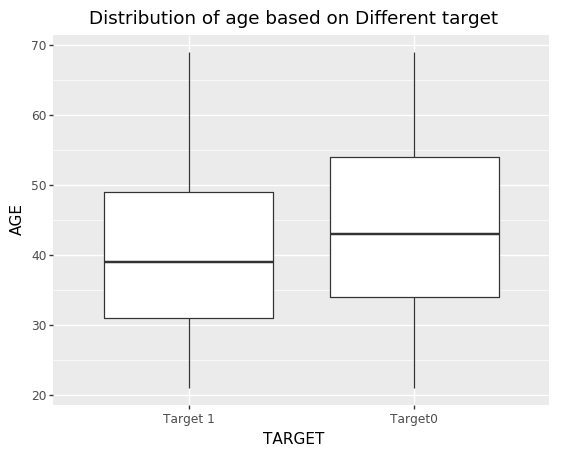

<ggplot: (-9223372029307660940)>

In [68]:
# Feature: AGE
P1 = p9.ggplot(df_combined) + p9.aes(x ='TARGET', y = "AGE") \
+ p9.labels.ylab("AGE")\
+ p9.geom_boxplot() + p9.labels.ggtitle('Distribution of age based on Different target')
P1

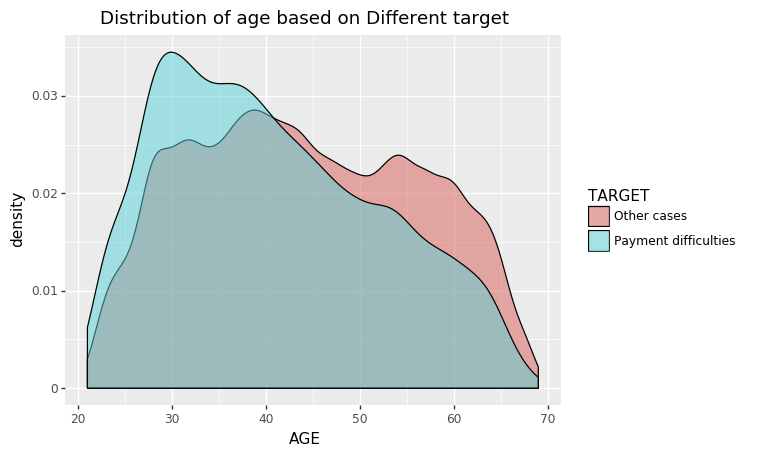

<ggplot: (-9223372029835609940)>

In [28]:
display(p9.ggplot(df_modified) + p9.aes('AGE',fill='TARGET') \
+ p9.labels.xlab("AGE")\
+ p9.geom_density(alpha=.5) + p9.labels.ggtitle('Distribution of age based on Different target'))

From this relationship, we find that there are obviously more young peopel faced with payment difficulties. The distribution of the "payment difficulties" group is highly right skewed. This reflects more young people don't have enough income to pay their loan. 

#### 3.5.2 Days of Last Phone Change

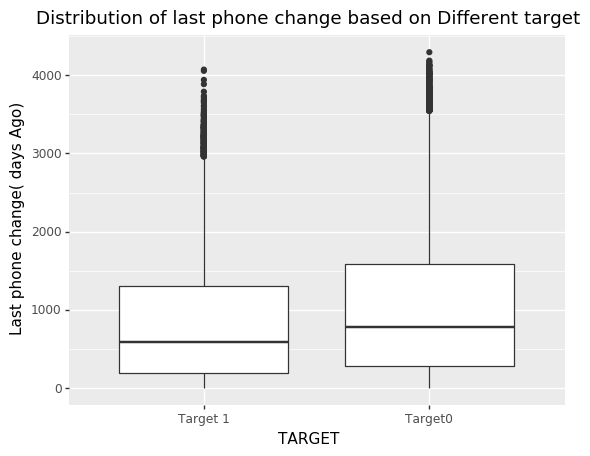

<ggplot: (7611494450)>

In [63]:
# Feature: DAYS_LAST_PHONE_CHANGE
P2 = p9.ggplot(df_combined) + p9.aes(x = 'TARGET', y = 'DAYS_LAST_PHONE_CHANGE') \
+ p9.labels.ylab("Last phone change( days Ago)")\
+ p9.geom_boxplot() + p9.labels.ggtitle('Distribution of last phone change based on Different target')
P2

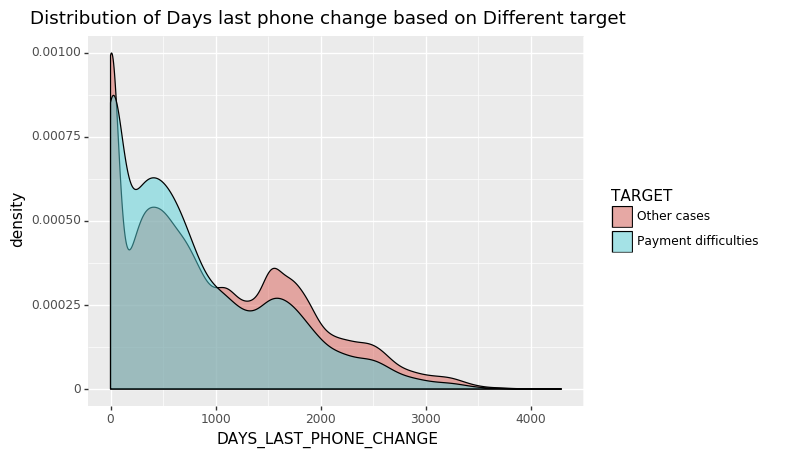

<ggplot: (7016417877)>

In [15]:
display(p9.ggplot(df_modified) + p9.aes('DAYS_LAST_PHONE_CHANGE',fill='TARGET') \
+ p9.labels.xlab("DAYS_LAST_PHONE_CHANGE")\
+ p9.geom_density(alpha=.5) + p9.labels.ggtitle('Distribution of Days last phone change based on Different target'))


Don't show some very clear differences in this distribution. Also the distribution also matches with our common sense. These apllicants who are credible has fewer reasons and smaller possibility to change their phone such as the prepaid phone.

#### 3.5.3 Days Credit Mean

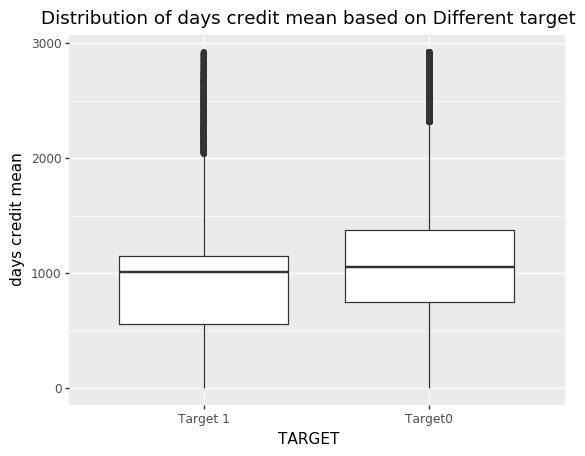

<ggplot: (-9223372029246401164)>

In [69]:
# Feature: DAYS_CREDIT_MEAN
P3 = p9.ggplot(df_combined) + p9.aes(x ='TARGET',y = 'DAYS_CREDIT_MEAN') \
+ p9.labels.ylab("days credit mean")\
+ p9.geom_boxplot() + p9.labels.ggtitle('Distribution of days credit mean based on Different target')

P3

#### 3.5.4 Days Employed

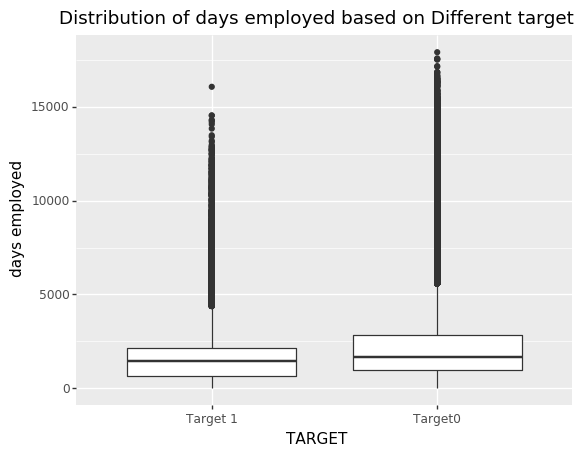

<ggplot: (7608498394)>

In [70]:
# Feature: DAYS_EMPLOYED
P4 = p9.ggplot(df_combined) + p9.aes(x = 'TARGET', y = 'DAYS_EMPLOYED') \
+ p9.labels.ylab("days employed")\
+ p9.geom_boxplot() + p9.labels.ggtitle('Distribution of days employed based on Different target')

P4

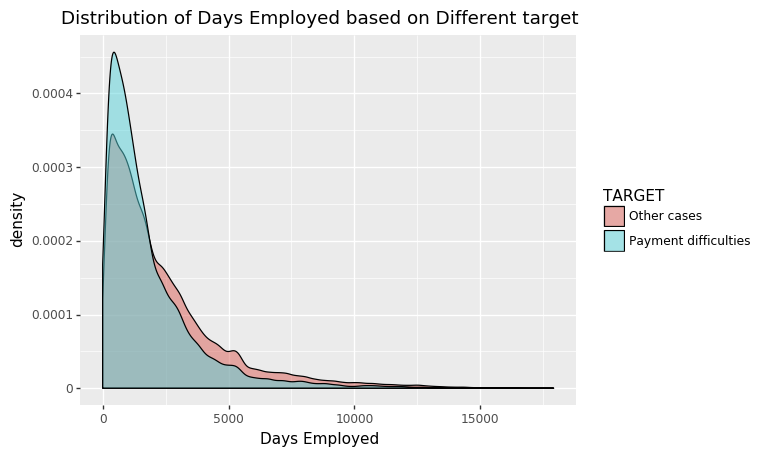

<ggplot: (7018351757)>

In [14]:
display(p9.ggplot(df_modified) + p9.aes('DAYS_EMPLOYED',fill='TARGET') \
+ p9.labels.xlab("Days Employed")\
+ p9.geom_density(alpha=.5) + p9.labels.ggtitle('Distribution of Days Employed based on Different target'))

This plot matches our common sense: customers with payment difficulties tend to have less working experience which also indicates the applicant will have lower income than other experienced worker. They don't have a high level salary so that they may not be able to pay their loans. 

#### 3.5.5 Days Registration

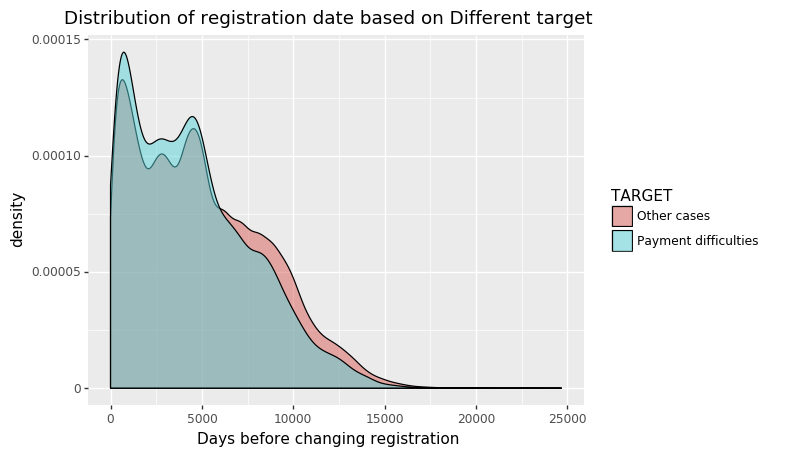

<ggplot: (-9223372029835609940)>

In [29]:
display(p9.ggplot(df_modified) + p9.aes('DAYS_REGISTRATION',fill='TARGET') \
+ p9.labels.xlab("Days before changing registration")\
+ p9.geom_density(alpha=.5) + p9.labels.ggtitle('Distribution of registration date based on Different target'))

From this plot,more people with payment difficulties change their registration relatively closely. However, we don't know what exactly the registration means. If this registration means loan registration, it seems to make sense because people who have payment difficulties may register in different companies to borrow some loans. 

#### 3.5.6 Loan Annuity

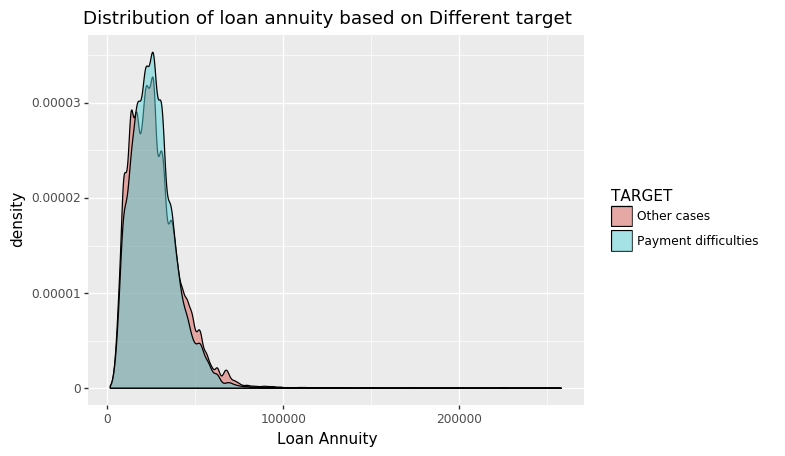

<ggplot: (-9223372029838345626)>

In [13]:
display(p9.ggplot(df_modified) + p9.aes('AMT_ANNUITY',fill='TARGET') \
+ p9.labels.xlab("Loan Annuity")\
+ p9.geom_density(alpha=.5) + p9.labels.ggtitle('Distribution of loan annuity based on Different target'))

In this plot, the spread of the group with "payment difficulties" is more tight, which means the variation of group with "payment difficulties" is smaller. We believe this is because those customer who use this service and those with "payment difficulties" usually do not have enough credit to borrow a large amount of loan. Thus, their variation tends to be smaller. Also the distribution of payment difficulties is simalar to the distribution of other case. It indcates those who have payment difficulites have is strongly related to the pdf of loan.

### 3.6 Hierarchical Clustering

Due to the assumption of correaltion, we can only find the pariwise linear realtionship between features.
Thus we need other method such as hierarchical clustering help us further analyze app_train.

Due to memory issue, we can only use roughly 50000 observations 

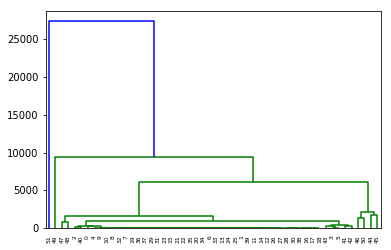

In [9]:
# Perform Hierarchical Clustering
Z_t = shc.linkage(df_modified.iloc[:,1:].T,method='ward')
de_t = shc.dendrogram(Z_t)

In [10]:
# Cut the tree into 2 clustering
tree_split_t = shc.cut_tree(Z_t,n_clusters=2)
feature_tree_2 = pd.DataFrame(data = tree_split_t, index=list(df_modified.iloc[:,1:].T.index),columns=['cluster group'])

In [12]:
# Cut the tree into 4 clustering
tree_split_t4=shc.cut_tree(Z_t,n_clusters=4)
feature_tree_4=pd.DataFrame(data=tree_split_t4,index=list(df_modified.iloc[:,1:].T.index),columns=['cluster group'])
feature_tree_4

,cluster group
TARGET,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_ANNUITY,0
AMT_GOODS_PRICE,0
REGION_POPULATION_RELATIVE,0
AGE,0
DAYS_EMPLOYED,0
DAYS_REGISTRATION,0
